# Cost-Sensitive Loan Approval Modeling: Reducing Default Risk with Precision-Focused Classification

## Overview
FinTech Innovations sought to automate and improve its manual loan approval process, which was slow, inconsistent, and costly. Using a classification-based machine learning pipeline, we prioritized precision to reduce the approval of high-risk applicants — a mistake that costs the company $50,000 per defaulted loan. After testing multiple models, logistic regression emerged as the best option, delivering 92.8% precision and 92.6% F1 score on unseen data. A custom cost-based evaluation showed that the model limited potential financial loss while maintaining strong overall accuracy. Feature importance analysis guided actionable business recommendations, such as targeting high-income, low-debt applicants and setting stricter thresholds for risk indicators like bankruptcy history and high loan amounts. The model is ready for production deployment with safeguards for retraining and fairness auditing.

#1. Business Understanding
Understanding the business objectives and transnlating them into specific data mining goals.

## Business Understanding

1. Begin by thoroughly analyzing the business context of FinTech Innovations' loan approval process. Write a short summary that:
- Describes the current manual process and its limitations
- Identifies key stakeholders and their needs
- Explains the implications of different types of model errors
- Justifies your choice between classification and regression approaches

The current manual loan approval process is performed by loan officers, which leads to inconsistent decisions and slow response times to applicants. This is because there are many different loan officers who are attempting to apply the same process, but human judgement can differ from person to person. Humans also do not work around the clock 24/7, can get sick, and take time off, which can lead to the slow response times.

The firm needs a robust machine learning pipeline that can automate approval decisions via a classification model, or a regression model that can generate risk scores that can support loan officers' decisions.

In this case, model errors can be false positives which would lead to identifying applicants as low risk and result in a loan approval, when they are actually high risk and should be denied. This would lead to loss of revenue. There would be a cost of approving bad loans that default, with an average loss on defaulted loan of $50,000 (including principal and collection costs).

There can also be false negatives which would lead to identifying applicants as high risk and result in a loan denial, when they are actually low risk and should be approved. This would also lead to loss of revenue. There would be a cost to denying loans to creditworth applicants, with an average profit loss per missed good loan of $8,000.

The risk/cost of a false positive (approval of bad loans that default) is much greater than the risk/cost of a false negative (denial of loan to creditworthy applicants). Therefore the model must be a classification model with focus on precision since there is such a higher cost associated with a false positive/bad loan that will default.

2. Define your modeling goals and success criteria:
- Select appropriate evaluation metrics based on business impact
- You must use at least two different metrics
- Consider creating custom metric
- Establish baseline performance targets
- Document your reasoning for each choice

The evaluation metrics that will be used will be precision and f1 score. Precision is especially important because the false positives in this situation are particularly costly. The f1 score will also be used because there still needs to be some balance between precision and recall, and there needs to be some attention paid to false negatives, which are also costly.

Create a custom cost-based metric that assigns actual dollar costs to false positives and false negatives. $50,000 for false positive, and $8,000 for false negative. True positives and True negatives will have $0 cost. This optimizes for financial impact, not just recall or F1, and helps quantatively compare models in terms of bottom-line performance.

Baseline precision target will be set at 0.9, and F1 will be set at 0.8. To strongly minimize false positives due to their high cost, and f1 is a little more relaxed because the balance we want to achieve and the lower cost of false positives.

## Data Understanding
3. Conduct comprehensive exploratory data analysis:
- Describe basic data characteristics
- Examine distributions of all features and target variables
- Investigate relationships between features
- Create visualizations to help aid in EDA
- Document potential data quality issues and their implications

4. Develop feature understanding:
- Categorize features by type (numerical, categorical, ordinal)
- Identify features requiring special preprocessing
- Document missing value patterns and their potential meanings
- Note potential feature engineering opportunities


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

# load data
df_loans = pd.read_csv('financial_loan_data.csv')

#2. Exploratory Data Analysis (EDA)
Explore the data and analyze to understand its characteristics. Identify potential problems and determine relevance to business goals.


In [2]:
# EDA Code Here - Create New Cells As Needed

# examine the data via initial inspection
print(f"\nDataset info:\n{df_loans.info()}")
print(f"\nFirst few rows of dataset:\n{df_loans.head()}")
print(f"\nDimensions of dataset:\n{df_loans.shape}")
print(f"\nClass distribution:\n{df_loans['LoanApproved'].value_counts(normalize=True) * 100}")

# check for missing values
missing_values = df_loans.isnull().sum()
print(f"\nMissing values in each column:\n{missing_values}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  object 
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              19099 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               18669 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

In [3]:
# ----- EXPLORATORY DATA ANALYSIS -----
print("\n===== COMPREHENSIVE DATA EXPLORATION =====\n")

# print out unique values in columns where dtype is object
for col in df_loans.select_dtypes(include='object'):
  print(f"\nUnique values in {col}:")
  print(df_loans[col].unique())


===== COMPREHENSIVE DATA EXPLORATION =====


Unique values in AnnualIncome:
['$39,948.00' '$39,709.00' '$40,724.00' ... '$30,180.00' '$41,025.00'
 '$53,227.00']

Unique values in EmploymentStatus:
['Employed' 'Self-Employed' 'Unemployed']

Unique values in EducationLevel:
['Master' 'Associate' 'Bachelor' 'High School' nan 'Doctorate']

Unique values in MaritalStatus:
['Married' 'Single' nan 'Divorced' 'Widowed']

Unique values in HomeOwnershipStatus:
['Own' 'Mortgage' 'Rent' 'Other']

Unique values in BankruptcyHistory:
['No' 'Yes']

Unique values in LoanPurpose:
['Home' 'Debt Consolidation' 'Education' 'Other' 'Auto']


In [4]:
# convert annualincome column from object to float
df_loans['AnnualIncome'] = df_loans['AnnualIncome'].replace('[\$,]', '', regex=True).astype(float)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\jtlee\AppData\Local\Temp\ipykernel_19908\3823979895.py:2: SyntaxWarning: invalid escape sequence '\$'
  df_loans['AnnualIncome'] = df_loans['AnnualIncome'].replace('[\$,]', '', regex=True).astype(float)


In [5]:
# basic statistical summary
numeric_features = df_loans.select_dtypes(include = ['int64', 'float64']).columns.tolist()

# Exclude 'LoanApproved' and 'RiskScore'
numeric_features = [col for col in numeric_features if col not in ['LoanApproved', 'RiskScore']]

categorical_features = df_loans.select_dtypes(include =['object']).columns.tolist()

print(f"Numerical feature statistics:\n{df_loans[numeric_features].describe()}")

print(categorical_features)

Numerical feature statistics:
                Age   AnnualIncome   CreditScore    Experience     LoanAmount  \
count  20000.000000   20000.000000  20000.000000  20000.000000   20000.000000   
mean      39.752600   59161.473550    571.612400     17.522750   24882.867800   
std       11.622713   40350.845168     50.997358     11.316836   13427.421217   
min       18.000000   15000.000000    343.000000      0.000000    3674.000000   
25%       32.000000   31679.000000    540.000000      9.000000   15575.000000   
50%       40.000000   48566.000000    578.000000     17.000000   21914.500000   
75%       48.000000   74391.000000    609.000000     25.000000   30835.000000   
max       80.000000  485341.000000    712.000000     61.000000  184732.000000   

       LoanDuration  NumberOfDependents  MonthlyDebtPayments  \
count  20000.000000        20000.000000         20000.000000   
mean      54.057000            1.517300           454.292700   
std       24.664857            1.386325         

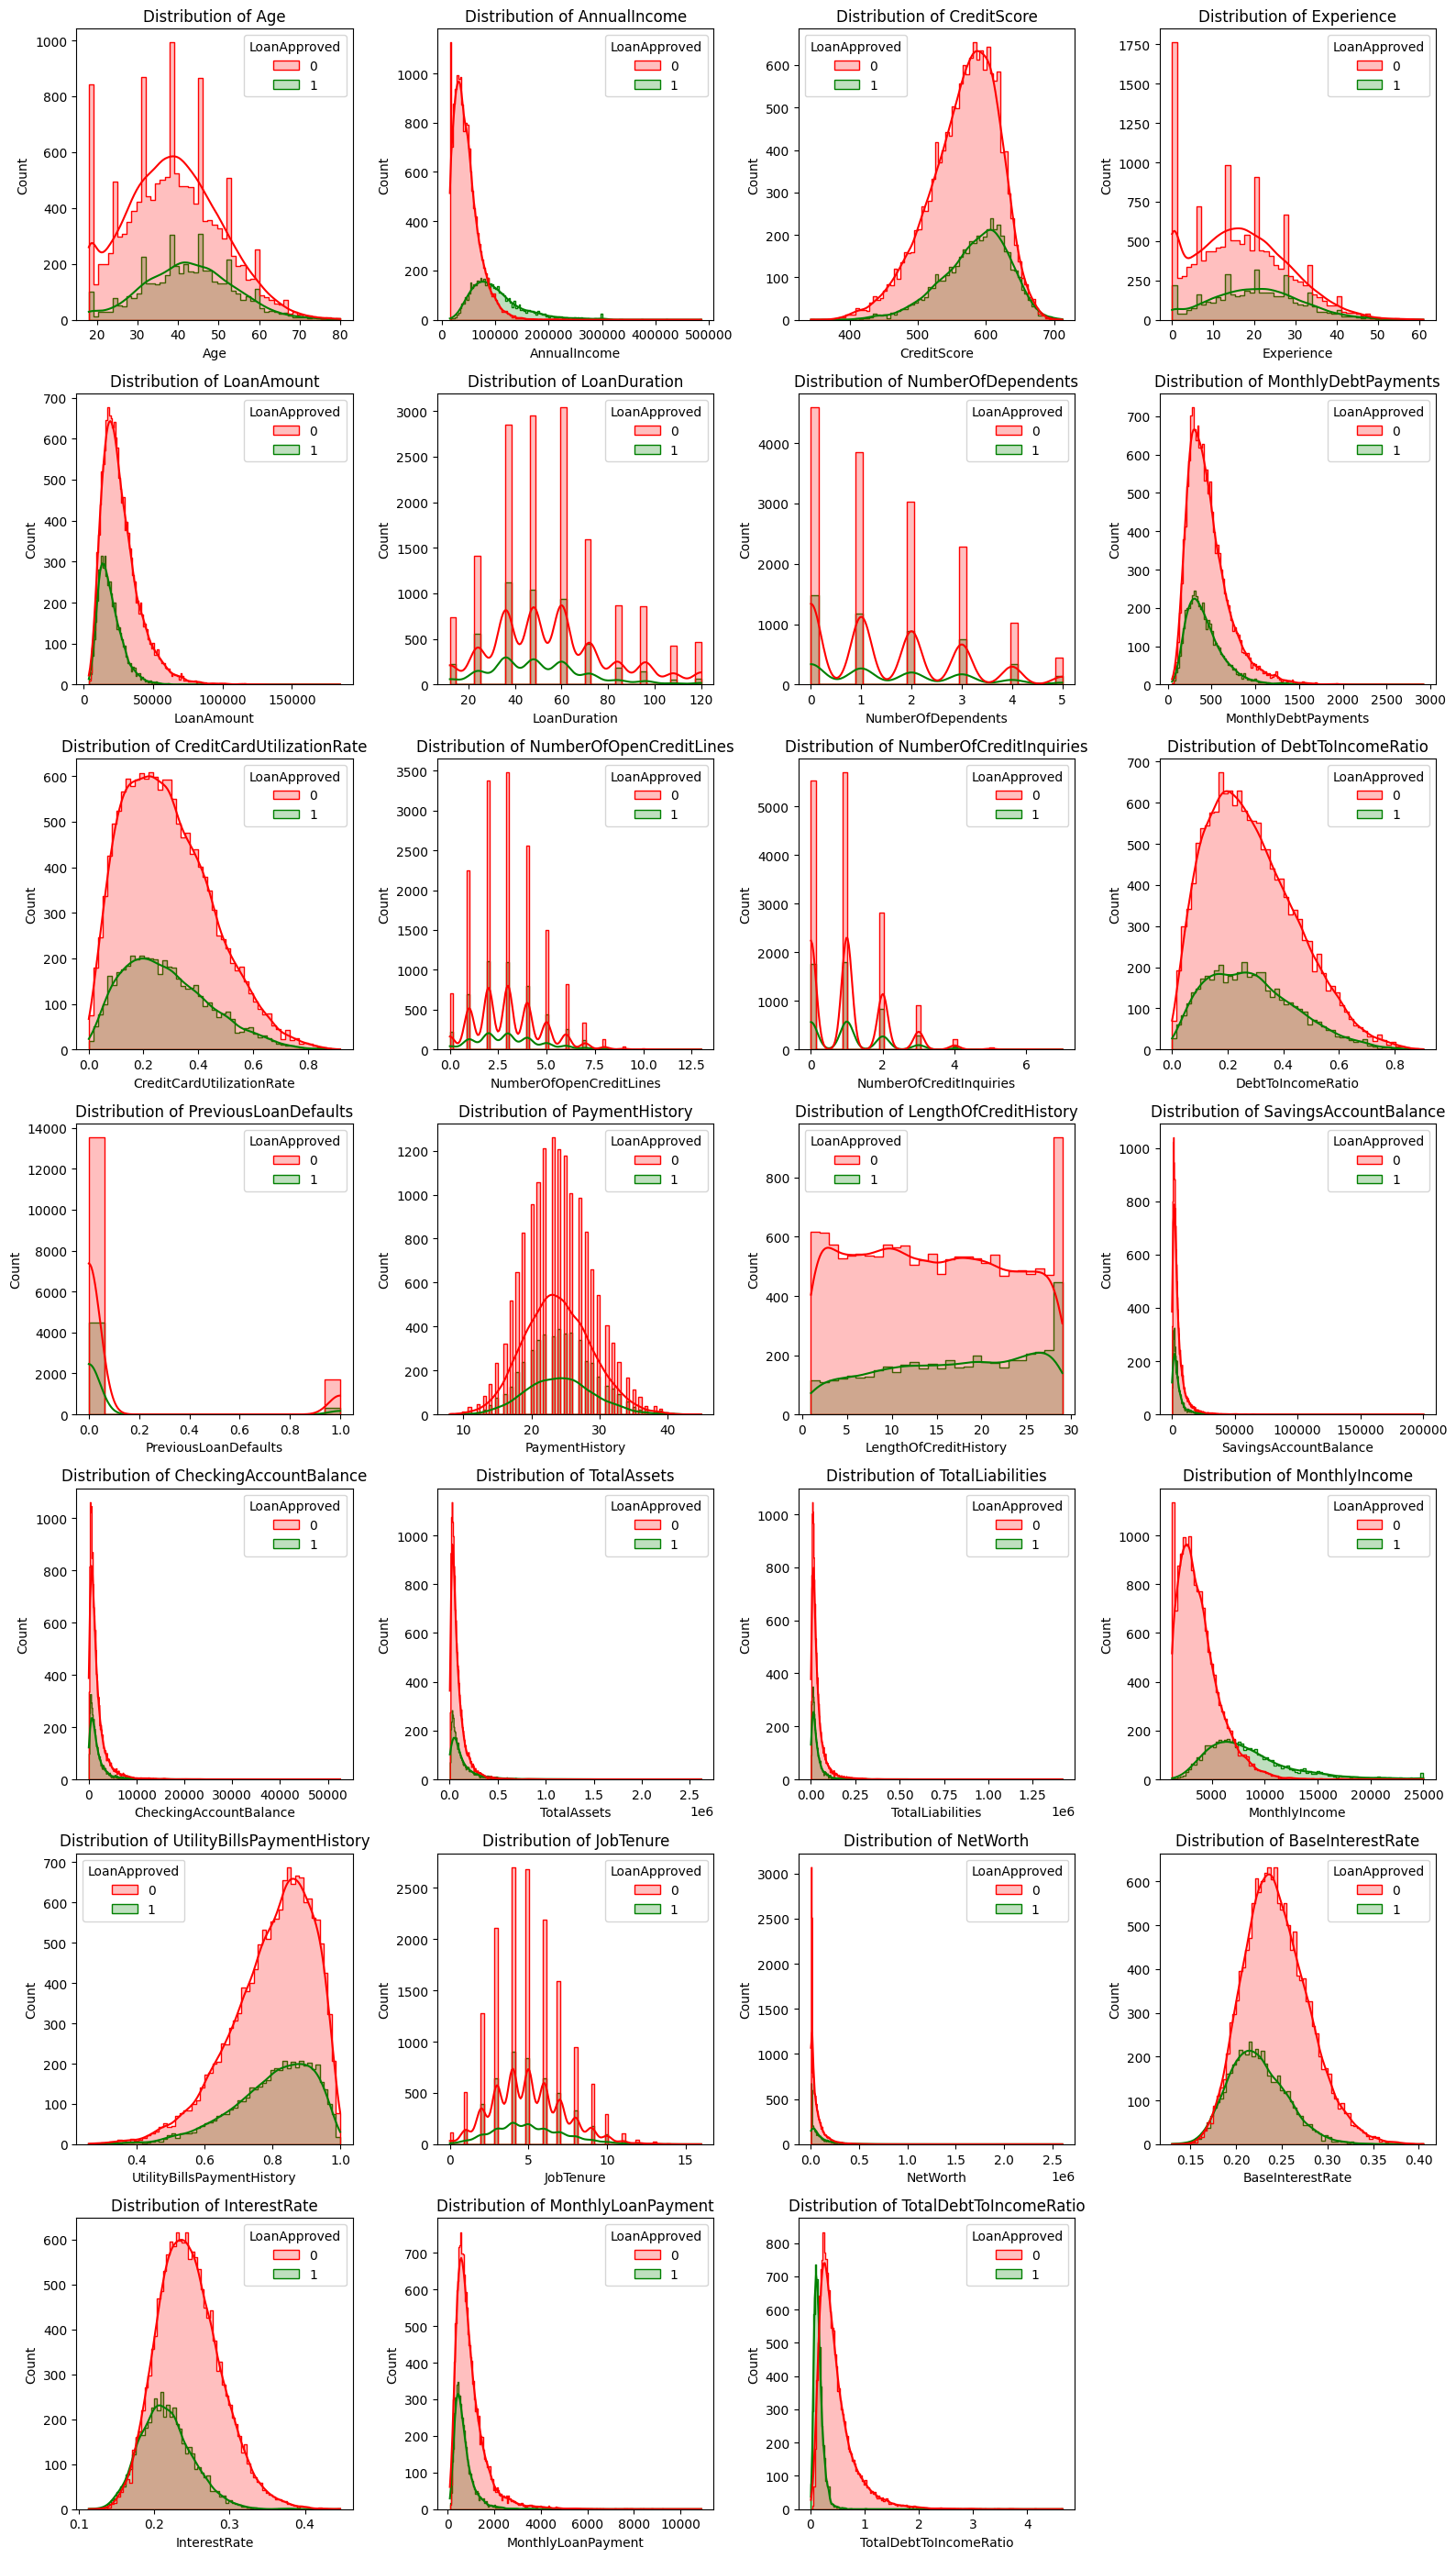

array([0, 1], dtype=int64)

In [6]:
# examine distribution of each numeric feature
n = len(numeric_features)
rows = int(np.ceil(n / 4))
plt.figure(figsize=(16, 4 * rows))

# plot histograms of numerical features

for i, feature in enumerate(numeric_features):
  plt.subplot(rows, 4, i+1)
  sns.histplot(data=df_loans, x=feature, hue='LoanApproved', kde=True, element='step', palette = ['red', 'green'])
  plt.title(f"Distribution of {feature}")
  plt.xlabel(feature)
  plt.ylabel("Count")

plt.tight_layout()
plt.show()

# previous loan defaults should be a categorical feature

df_loans['PreviousLoanDefaults'].unique()

Obvious differences in loan approvals are total debt to income ratio, risk score, monthly loan payment, base interest rate, interest rate, total liabilities, total assets, and monthly income.

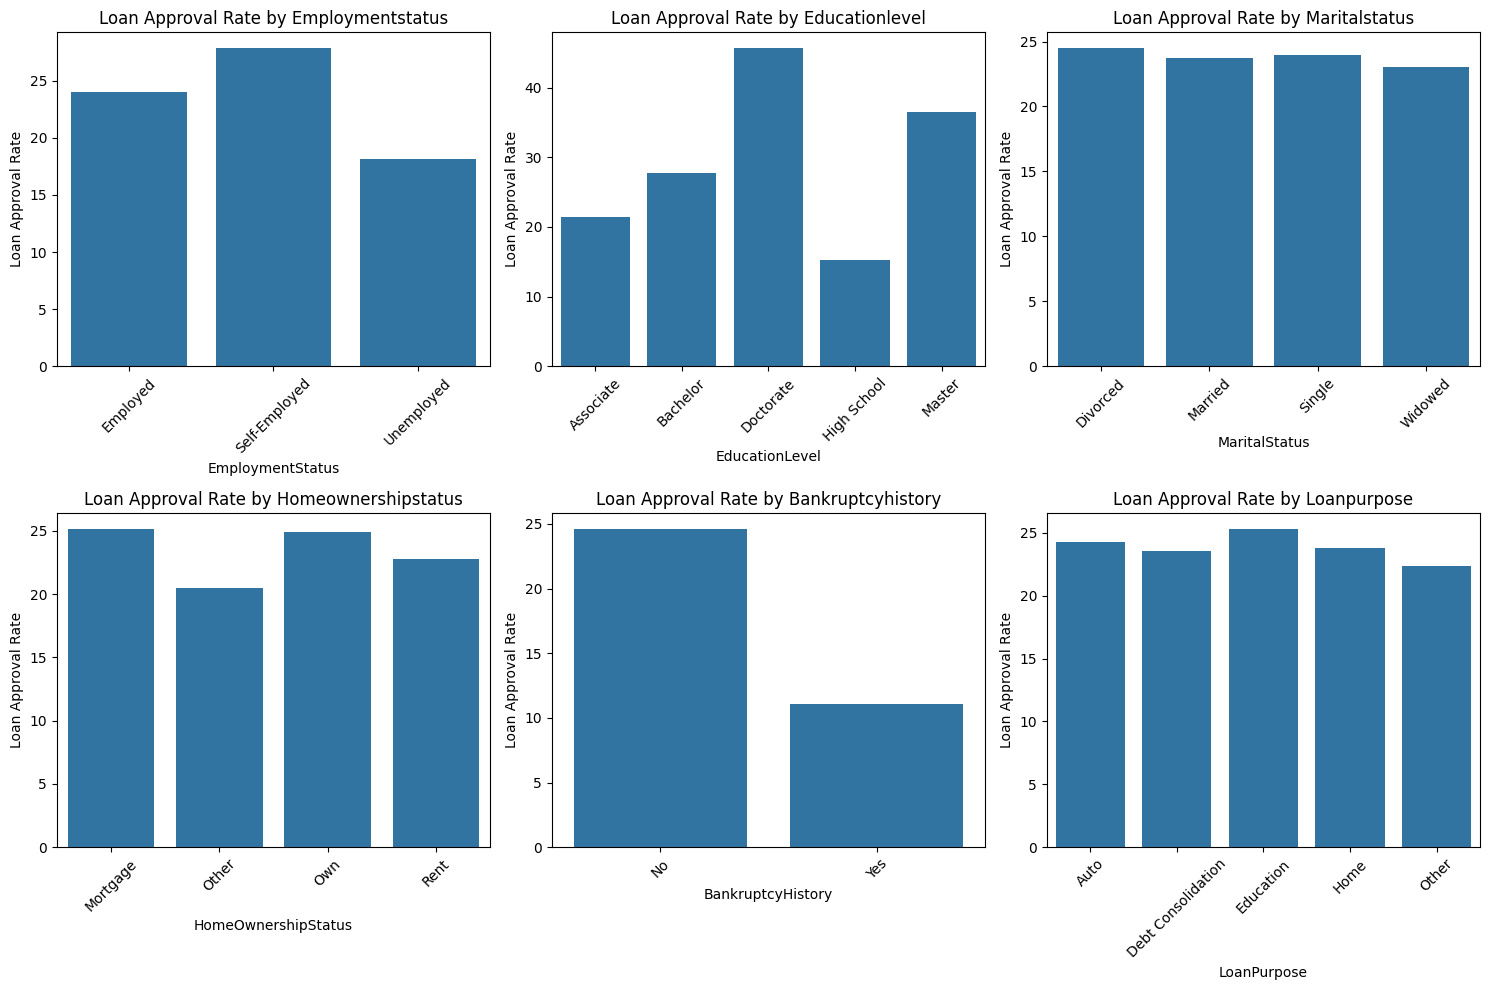

In [7]:
# visualize categorical feature relations
# use pandas groupby to calculate LoanApproved means for each categorical variable
# convert values to percentage (multiply each by 100)

# Set number of columns per row
plots_per_row = 3
total_plots = len(categorical_features)
rows = math.ceil(total_plots / plots_per_row)

# Create figure
plt.figure(figsize=(5 * plots_per_row, 5 * rows))

# Loop through and plot
for i, feature in enumerate(categorical_features, 1):  # start at 1 for subplot indexing
    approval_rates = df_loans.groupby(feature)['LoanApproved'].mean() * 100

    plt.subplot(rows, plots_per_row, i)
    sns.barplot(x=approval_rates.index, y=approval_rates.values)
    plt.title(f"Loan Approval Rate by {feature.replace('_', ' ').title()}")
    plt.ylabel("Loan Approval Rate")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Obvious differences in loan approval in categorical features are bankrupty history, previous loan defaults, education level, and employment status.

Education level, marital status, and savings account balance will need special preprocessing.

Nans in Education and marital status will need to be one hot encoded as ignore. Nans in savings account balance will have to be imputed as the median.

Apply ordinal encoding to education level, as there is a clear order from high school, associate, bachelor, master, doctorate.



#3. Data Preparation

Clean, transform, and prepare data for modeling, ensuring it is suitable for analysis.


## Data Preparation
5. Design your preprocessing strategy:
- Create separate preprocessing flows for different feature types
- Must utilize ColumnTransformer and Pipeline
- Consider using FeatureUnion as well
- Handle missing values appropriately for each feature
- Handle Categorical and Ordinal data appropriately
- Scale numeric values if model requires it (linear model)
- Document your reasoning for each preprocessing decision



In [8]:
print(f"\nNumeric features:\n{numeric_features}")
print(f"\nCategorical features:\n{categorical_features}")

numeric_features = [col for col in numeric_features if col not in ['AnnualIncome']]

# exclude 'educationlevel' from categorical_features, and add to ordinal features
# exclude 'bankruptcyhistory' from categorical_features and add to binary features
categorical_features = [col for col in categorical_features if col not in ['EducationLevel', 'BankruptyHistory']]

ordinal_features = ['EducationLevel']
print(f"\nOrdinal features:\n{ordinal_features}")

binary_features = ['BankruptcyHistory']
print(f"\nBinary features:\n{binary_features}")


Numeric features:
['Age', 'AnnualIncome', 'CreditScore', 'Experience', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio']

Categorical features:
['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'BankruptcyHistory', 'LoanPurpose']

Ordinal features:
['EducationLevel']

Binary features:
['BankruptcyHistory']


In [9]:
# want to both raw scaled and log-transformed versions of annual income

# Raw scaled income
raw_scaled = Pipeline([
    ('scaler', StandardScaler())
])

# Log-transformed scaled income
log_scaled = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# Combine both
income_union_transformer = FeatureUnion([
    ('raw', raw_scaled),
    ('log', log_scaled)
])

# create transformer for numerical features
# create a pipeline with imputation and standard scaling
# fill null values with median, as the only column with nans is savingsaccountbalance
# whcih can be skewed

numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),    # fill missing with median
    ('scaler', StandardScaler()),   # scale feature to have mean=0, variance = 1
])

# create transformer for categorical features
# create a pipeline with imputation and onehotencoding
# educationlevel and maritalstatus have nans which are imputed before one hot encoding

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'))
])

# create transformer for ordinal features
# create a pipeline wtih imputation and ordinalencoder

edu_order = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']]
ordinal_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder(categories=edu_order))
])

# create transformer for binary features
# create a pipeline with imputation and ordinal encoder

binary_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder(categories=[['No', 'Yes']]))
])

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers = [
        ('income_dual', income_union_transformer, ['AnnualIncome']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bin', binary_transformer, binary_features),
    ]
)

In [10]:
# Data Prep Code Here - Create New Cells As Needed


#4. Modeling and Hyperparameter Tuning
Modeling techniques are selected, applied and evaluated to determine the best approach for achieving goals.

## Modeling
6. Implement your modeling approach:
- Choose appropriate model algorithms based on your problem definition
- Set up validation strategy with chosen metrics
- Use a train test split and cross validation
- Create complete pipeline including any preprocessing and model
- Document your reasoning for each modeling decision

7. Optimize your model:
- Define parameter grid based on your understanding of the algorithms
- Implement GridSearchCV and/or RandomizedSearchCV with chosen metrics
- Consider tuning preprocessing steps
- Track and document the impact of different parameter combinations
- Consider the trade-offs between different model configurations

NOTE: Be mindful of time considerations - showcase “how to tune”


In [11]:
#  Modeling Code Here - Create New Cells as Needed
# split data into features and target
# loan approved is target, risk score is dropped as it is an output of all the other features
# also drop risk score to minimize leakage risk
# separate target loanapproved to y
X = df_loans.drop(columns = ['LoanApproved', 'RiskScore'])
y = df_loans['LoanApproved']

# split into training and test sets (80% train, 20% test) use random state = 42 and set stratify = y
# random_state=42 to ensure reproducibility
# stratify y to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# create random forest pipeline (set random_state=42)
# random_state=42 ensures reproducibility
# random forest captures complex patterns and non-linearities
rf_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

# create logistic regression pipeline (set random_state=42 and max_iter=1000)
# random_state=42 to ensure reproducibility
# max_iter=1000 to avoid convergence issues in logistic regression
lr_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state = 42, max_iter = 1000))
])

In [12]:
# Define parameter distributions for random search
scoring = {
    'precision': 'precision',
    'f1': 'f1',
}

from scipy.stats import randint, reciprocal

# Define parameter distributions for random forest
rf_param_dist = {
    'classifier__max_depth': randint(5, 20),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__n_estimators': randint(50, 200),
    'classifier__class_weight': ['balanced', None],
}

# Define parameter distributions for logistic regression
lr_param_dist = {
    'classifier__C': reciprocal(0.01, 10.0),
    'classifier__class_weight': ['balanced', None],
    'classifier__solver': ['liblinear', 'saga']
}

rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=30,
    cv=5,
    scoring=scoring,
    refit='precision',
    return_train_score=True,
    random_state=42,
    n_jobs=-1
)

lr_random_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_param_dist,
    n_iter=20,  # logistic regression grid is smaller
    cv=5,
    scoring=scoring,
    refit='precision',
    return_train_score=True,
    random_state=42,
    n_jobs=-1
)

In [13]:
rf_random_search.fit(X_train, y_train)
lr_random_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'classifier__C': <scipy.stats....002A9F6F68E60>, 'classifier__class_weight': ['balanced', None], 'classifier__solver': ['liblinear', 'saga']}"
,n_iter,20
,scoring,"{'f1': 'f1', 'precision': 'precision'}"
,n_jobs,-1
,refit,'precision'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [14]:
print("Best Random Forest Parameters:")
print(rf_random_search.best_params_)

print("\nBest Logistic Regression Parameters:")
print(lr_random_search.best_params_)


Best Random Forest Parameters:
{'classifier__class_weight': None, 'classifier__max_depth': 11, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 100}

Best Logistic Regression Parameters:
{'classifier__C': 0.6847920095574779, 'classifier__class_weight': None, 'classifier__solver': 'saga'}


In [15]:
# optimization

# define parameter grid for random forest
rf_param_grid = {
    # preprocessing parameters
    # initially selected median, adding mean
    'preprocessor__num__imputer__strategy': ['median'],

    # model parameters
    'classifier__n_estimators': [90, 100, 110],
    'classifier__max_depth': [10, 11, 12, None],
    'classifier__min_samples_split': [5, 6, 7],
    'classifier__min_samples_leaf': [2, 3, 4],
    'classifier__class_weight': ['balanced', None]
}

# define parameter grid for logistic regression
lr_param_grid = {
    # preprocessing parameters
    # initially selected median, adding mean
    'preprocessor__num__imputer__strategy': ['median'],

    # model parameters
    'classifier__C': [0.1, 0.5, 0.68, 0.8, 1.0],
    'classifier__class_weight': ['balanced', None],
    'classifier__solver': ['liblinear', 'saga']
}

# define scoring
scoring = {
    'precision': 'precision',
    'f1': 'f1',
}

In [16]:
# perform grid search for random forest
rf_grid_search = GridSearchCV(
    rf_pipeline, rf_param_grid, cv=5, scoring=scoring, refit = 'precision', return_train_score=True, n_jobs=-1
)

# fit the random forest grid search
rf_grid_search.fit(X_train, y_train)

# perform grid search for logistic regression
lr_grid_search = GridSearchCV(
    lr_pipeline, lr_param_grid, cv = 5, scoring=scoring, refit = 'precision', return_train_score = True, n_jobs=-1
)

# fit the logistic regression grid search
lr_grid_search.fit(X_train, y_train)

# compare models
rf_best_cvscore = rf_grid_search.best_score_
lr_best_cvscore = lr_grid_search.best_score_

In [17]:
print("Best Random Forest Parameters:")
print(rf_grid_search.best_params_)

print("\nBest Logistic Regression Parameters:")
print(lr_grid_search.best_params_)

Best Random Forest Parameters:
{'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 110, 'preprocessor__num__imputer__strategy': 'median'}

Best Logistic Regression Parameters:
{'classifier__C': 0.5, 'classifier__class_weight': None, 'classifier__solver': 'saga', 'preprocessor__num__imputer__strategy': 'median'}


In [18]:
print(f"Best Random Forest precision_score: {rf_best_cvscore:.4f}")
print(f"Best Logistic Regression precision_score: {lr_best_cvscore:.4f}")

# Select the best model based on recall
if rf_best_cvscore >= lr_best_cvscore:
    best_model = rf_grid_search
    model_name = "Random Forest"
else:
    best_model = lr_grid_search
    model_name = "Logistic Regression"

print(f"\nBest model: {model_name}")

Best Random Forest precision_score: 0.8814
Best Logistic Regression precision_score: 0.9298

Best model: Logistic Regression


#5. Model Evaluation
Performance of chosen model is evaluated against business objectives.

## Evaluation and Conclusion
8. Conduct thorough evaluation of final model:
- Assess models test data performance using your defined metrics
- Analyze performance across different data segments
- Identify potential biases or limitations
- Visualize model performance
    - Classification: Confusion Matrix/ROC-AUC
    - Regression: Scatter Plot (Predicted vs. Actual values)

9. Extract and interpret feature importance/significance:
- Which features had the most impact on your model?
- Does this lead to any potential business recommendations?

10. Prepare your final deliverable:
- Technical notebook with complete analysis
- Executive summary for business stakeholders
- Recommendations for implementation
- Documentation of potential improvements

In [19]:
from sklearn.metrics import precision_score

# get the best model from gridsearch
final_model = best_model.best_estimator_

# make predictions on test set using final_model
y_pred = final_model.predict(X_test)

# calculate test set precision score
test_precision = precision_score(y_test, y_pred)

# calculate test set f1 score
test_f1 = f1_score(y_test, y_pred)

# create classification classification_report
cr = classification_report(y_test, y_pred)

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [20]:
print(f"\n==== Final Model Evaluation ====")
print(f"\nTest set precision score:\n{test_precision:.4f}")
print(f"\nTest set f1 score:\n{test_f1:.4f}")
print(f"\nClassification report:\n{cr}")


==== Final Model Evaluation ====

Test set precision score:
0.9276

Test set f1 score:
0.9261

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3044
           1       0.93      0.92      0.93       956

    accuracy                           0.96      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.96      0.96      0.96      4000



In [21]:
# Unpack confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate total cost
total_cost = fp * 50000 + fn * 8000
print(f"\nCustom Cost-Based Evaluation:\n- False Positives: {fp}\n- False Negatives: {fn}")
print(f"Total Financial Cost: ${total_cost:,}")


Custom Cost-Based Evaluation:
- False Positives: 69
- False Negatives: 72
Total Financial Cost: $4,026,000


Model performance based on metrics:
The final selected model, logistic regression was evaluated on the test set using the prefined metrics of precision and F1 score due to the high cost associated with false positives.
Precision was 0.9276, indicating that 93% of applicants predicted as loan worth were actually approved, minimizing costly false positives. F1 score was 0.9261, which balances both precision and recall, indicating overall strong performance. Accuracy was 96% a high result.

The final selected model has far outperformed the previously established baseline of 0.9 for precision and 0.8 for F1 score.

There were 69 False positives, resulting in lost $50,000 for each instance. And there were 72 false negatives, resulting in a loss of $8,000 each instance.
Overall, the total financial cost was a little over $4 million in bad loan costs and missed opportunities.

Biases and Limitations:
There may be bias from imbalanced classes. The class distributino of loanapproved was 76% vs 24%. Even though precision is high, recall for class 1 (approved) might suffer if the model overlearns from the dominant class.
There could be bias in this historical data. This data and the resulting decisions for loan approval were made by humans. Moving forward, if loan approvals are made automatically, there could be a shift in the future in decision making, as the pool of data and approval decisions made by humans becomes diluted by machine learning made decisions.
Additionally, there were many missing values in Education level and marital status that had to be imputed. Imputing with the most frequent class may reinforce overrepresented groups and distort marginal cases.
The current data is a snapshot in time of applicants and their economic, social, etc. situations. Things change, societal norms and people's circumstances change. So additional data needs to be gathered to inform the machine learning pipelines so they aren't based on dated data.

AUC was determined to be 0.995 which is almost a 1.0 perfect model. It is extremely capable of distinguishing between approved applicants (1) and denied applicants (0). The ROC curve plot shows a curve hugging the top left corner, indicating a very high true positive rate and very low false positive rate. Therefore this model is highly capable of ranking loan applicants by risk.


Confusion Matrix:
[[2975   69]
 [  72  884]]


c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


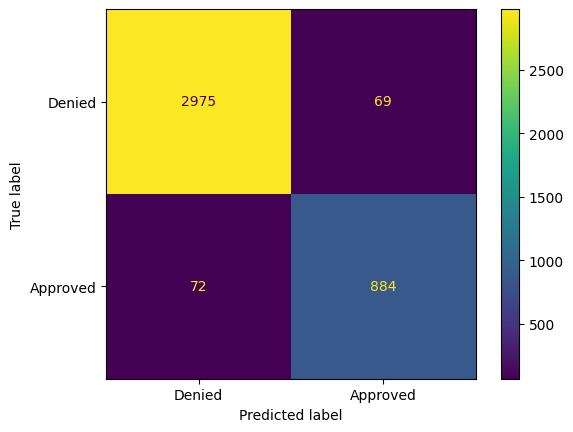

<Figure size 640x480 with 0 Axes>

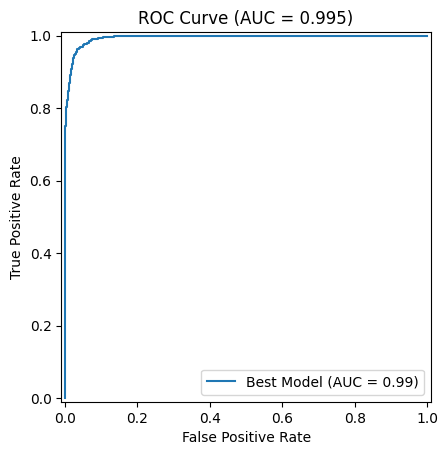

In [22]:
# visualize model performance
# for classification: confusion matrix and ROC-AUC

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

print(f"\nConfusion Matrix:\n{cm}")
ConfusionMatrixDisplay(cm, display_labels=['Denied', 'Approved']).plot()

# Get predicted probabilities for class 1
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot
plt.figure()
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Best Model').plot()
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

In [23]:
# Example: Analyze performance by EducationLevel
segment_col = 'EducationLevel'

for level in X_test[segment_col].dropna().unique():
    mask = X_test[segment_col] == level
    y_true = y_test[mask]
    y_pred = final_model.predict(X_test[mask])

    print(f"\nPerformance for Education Level: {level}")
    print(classification_report(y_true, y_pred, zero_division=0))


Performance for Education Level: Associate
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       620
           1       0.91      0.90      0.90       162

    accuracy                           0.96       782
   macro avg       0.94      0.94      0.94       782
weighted avg       0.96      0.96      0.96       782


Performance for Education Level: High School
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       920
           1       0.93      0.90      0.92       166

    accuracy                           0.98      1086
   macro avg       0.96      0.95      0.95      1086
weighted avg       0.97      0.98      0.97      1086


Performance for Education Level: Bachelor
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       838
           1       0.95      0.94      0.94       325

    accuracy                           0.97      

#6. Conclusion Insights and Business recommendations

The feature that had the most impact on the model are those in the plot above. Total debt to income ratio, interest rate, bankrupty history, employment status of unemployed, loan amount and credit score had the most negative impact on a loan approval in this model. Monthly income, net worth, and length of credit history had the most positive impact on a loan approval in this model.

This leads to several business recommendations. The firm should continue to place a high value on applicants with high monthly income, networth, and long history of credit. The marketing department and sales should allocate resources to seek out potential applicants that have these characteristics.
On the other hand, the firm should continue to look out for potential applicants who have bad total debt to income ratio, poor credit resulting in high interest rates, a history of bankrupty, unemployed status, and high laon amounts. Applicants with these characteristics are risky, and could cost the firm a lot of money. There should be thresholds put in place for these data points for applicants thare are an absolute deny. Attention should be given to applicants who have some of these features. Some of them even though they have red flags for risk, could be potential approvals, but special care and consideration should be given to their net worth, credit history and monthly income.


Executive summary:
The final model achieved 92.8% precision and 92.6% F1 score on the test set, minimizing financial risk by avoiding high-cost false positives. The logistic regression model was chosen for its interpretability and strong performance. Feature analysis revealed key drivers of approval (e.g., high income, low debt), guiding future applicant targeting strategies. The model is suitable for production deployment with periodic retraining and fairness review